In [1]:
# coding: utf-8

import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import sys
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pickle
import os

In [2]:
sim = "CTRL"
st = f"/chinook/marinier/CONUS_2D/{sim}"

datai = 2001
dataf = 2002

store = '/chinook/cruman/Data/Near0Events'
ns = 1e-9

# Need to change this size later, as the grid is much larger now  
xi=1015 #153
yi = 1359 #166
#xi = 153
#yi = 166
#1015, 1359
aux = np.full((xi, yi), True)
aux13 = np.full((xi, yi), True)
aux24 = np.full((xi, yi), True)
aux1 = np.full((xi, yi), True)
aux2 = np.full((xi, yi), True)
aux3 = np.full((xi, yi), True)
aux4 = np.full((xi, yi), True)

aux_true = np.full((xi, yi), True)
aux_false = np.full((xi, yi), False)

aux_pr = np.full((xi, yi), False)

ini = True
for y in range(datai, dataf+1):
    print(f"Year: {y}")

    for m in range(1, 13):

  # Open Dataset
        print(f"Month: {m}")
        if 1 <= m <= 3:
            mi = 1
            mf = 3
        elif 4 <= m <= 6:
            mi = 4
            mf = 6
        elif 7 <= m <= 9:
            mi = 7
            mf = 9
        else:
            mi = 10
            mf = 12

        if (y == 2000) and m < 10:
            continue

        if (y == 2013) and m > 9:
            continue
            
        t2 = xr.open_dataset(f'{st}/{y}/wrf2d_d01_CTRL_T2_{y}{mi:02d}-{y}{mf:02d}.nc', engine='netcdf4')
        pr = xr.open_dataset(f'{st}/{y}/wrf2d_d01_CTRL_PREC_ACC_NC_{y}{mi:02d}-{y}{mf:02d}.nc', engine='netcdf4')
        
        # Slicing the domain to make the computations faster
        #i1=721; j1=1167; i2=874; j2=1333
        t2 = t2.T2
        
        pr = pr.PREC_ACC_NC 
        sys.exit()
        xlat = t2.XLAT
        xlon = t2.XLONG
        #t2 = t2[:,i1:i2,j1:j2] 
        #pr = pr[:,i1:i2,j1:j2]
        
        t2 = t2 - 273.15
        
        datai = datetime.strptime(f'{y}-{m:02d}-01 00:00', '%Y-%m-%d %H:%M')
        dataf = datetime.strptime(f'{y}-{m:02d}-01 00:00', '%Y-%m-%d %H:%M')
        dataf += relativedelta(months=1)
        dataf -= relativedelta(hours=1)

        #print(wsn)

        t2 = t2.sel(Time=slice(datai.strftime('%Y-%m-%d %H:%M'), dataf.strftime('%Y-%m-%d %H:%M')))
        pr = pr.sel(Time=slice(datai.strftime('%Y-%m-%d %H:%M'), dataf.strftime('%Y-%m-%d %H:%M')))
        
        # first timestep: Set the aux array
        aux = np.logical_and(t2[0]<2, t2[0]>-2)
        
        if not ini:
            # Attach the last value to the first value of the next month.
            #ini = False
            print('ini == false')
            t2 = xr.concat([lastT2, t2], dim='Time')
            pr = xr.concat([lastPR, pr], dim='Time')
            
            lastT2 = t2[-1,:,:]
            lastPR = pr[-1,:,:]
            sys.exit()
        else:
            lastT2 = t2[-1,:,:]
            lastPR = pr[-1,:,:]
            ini = False
            print('ini == true')

        # second timestep onward: follow the algorithm
        for i in range(1,t2.shape[0]):
            # if the aux == False, event not in place. set the entryways
            # set aux13 and aux24
            new_aux = np.logical_and(t2[i]>-2, t2[i]<2)

            aux13 = np.where((aux==False) & (t2[i-1] > 2), aux_true, aux13)
            aux24 = np.where((aux==False) & (t2[i-1] < -2), aux_true, aux24)
            # I need to keep the previous values of aux13 and aux24 here. if aux=true

            # if the aux == True, event in place. 
            # If the current temperature is between -2 and 2, do nothing. aux continues = True
            # if not, event finished. Calculate the entryways. set aux = False
            aux_pr = np.where((pr[i] > 0.1), aux_true, aux_pr)
            
            aux3_bool = ((aux13==True) & (t2[i] > 2)) & (aux == True)      
            aux3 += np.where(aux3_bool & aux_pr, aux_true, aux_false)
            
            aux3 += np.where(((aux13==True) & (t2[i] > 2)) & (aux == True), aux_true, aux_false)            
            aux2 += np.where(((aux24==True) & (t2[i] > 2)) & (aux == True), aux_true, aux_false)

            aux1 += np.where(((aux13==True) & (t2[i] < -2)) & (aux == True), aux_true, aux_false)
            aux4 += np.where(((aux24==True) & (t2[i] < -2)) & (aux == True), aux_true, aux_false)

            # I need to 'reset' the aux13 and aux24
            aux13 = np.where((aux13==True) & (t2[i] > 2), aux_false, aux13)            
            aux13 = np.where((aux13==True) & (t2[i] < -2), aux_false, aux13)
            aux24 = np.where((aux24==True) & (t2[i] > 2), aux_false, aux24)
            aux24 = np.where((aux24==True) & (t2[i] < -2), aux_false, aux24)

            aux = new_aux
        
        # Save stuff, reset aux1234.
        
        aux1 = np.zeros((xi, yi))
        aux2 = np.zeros((xi, yi))
        aux3 = np.zeros((xi, yi))
        aux4 = np.zeros((xi, yi))
        #sys.exit()
        

Year: 2001
Month: 1


SystemExit: 

/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3435: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [18]:
aux_pr = np.where((pr[i] > 1), aux_true, aux_pr)

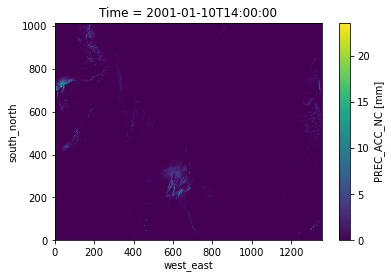

In [12]:
pr[230].plot()

In [20]:
aux3_bool & aux_pr

<xarray.DataArray 'T2' (south_north: 1015, west_east: 1359)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    XLAT     (south_north, west_east) float32 18.14 18.15 18.15 ... 52.43 52.42
    XLONG    (south_north, west_east) float32 -122.9 -122.8 ... -57.0 -56.95
Dimensions without coordinates: south_north, west_east

In [93]:
xr.concat([lastT2, t2],dim='Time')

<xarray.DataArray 'T2' (south_north: 153, west_east: 166, Time: 673)>
array([[[ -7.5295715,  -7.068512 ,  -8.361359 , ..., -12.981354 ,
         -14.939606 , -16.761414 ],
        [ -7.0256042,  -6.4879456,  -6.8005676, ..., -11.730286 ,
         -14.854584 , -17.527588 ],
        [ -6.1358337,  -5.94046  ,  -5.792328 , ..., -10.294434 ,
         -13.486481 , -16.034119 ],
        ...,
        [  1.5761719,   2.0255127,   2.1526184, ...,  -4.9477234,
          -5.1231384,  -5.139435 ],
        [  1.6474304,   2.0589905,   2.1606445, ...,  -4.890564 ,
          -5.053406 ,  -5.083191 ],
        [  1.7186584,   2.0856628,   2.1743774, ...,  -4.843292 ,
          -4.987793 ,  -5.0151367]],

       [[ -6.7939453,  -6.0082703,  -9.172272 , ..., -11.7786255,
         -13.113251 , -15.191956 ],
        [ -6.0405273,  -5.9065247,  -6.576294 , ..., -10.720551 ,
         -12.578278 , -17.087769 ],
        [ -5.331604 ,  -5.5279236,  -5.5526733, ..., -10.279053 ,
         -12.066711 , -16.960999 ],
...
        [ -9.545288 ,  -9.389648 ,  -9.051056 , ..., -16.754425 ,
         -17.501175 , -17.973907 ],
        [ -9.505707 ,  -9.375519 ,  -9.054321 , ..., -16.723907 ,
         -17.545624 , -17.936157 ],
        [ -9.430542 ,  -9.282837 ,  -9.010468 , ..., -16.73642  ,
         -17.653336 , -17.91484  ]],

       [[-26.750809 , -26.567978 , -26.772446 , ..., -21.910614 ,
         -27.035828 , -27.803589 ],
        [-26.06314  , -27.405624 , -27.2341   , ..., -22.110321 ,
         -25.487991 , -27.320953 ],
        [-25.986115 , -27.42514  , -27.563568 , ..., -22.286713 ,
         -24.925201 , -27.322601 ],
        ...,
        [ -9.623749 ,  -9.448944 ,  -9.105408 , ..., -16.75592  ,
         -17.430252 , -18.056152 ],
        [ -9.566315 ,  -9.411499 ,  -9.103638 , ..., -16.73108  ,
         -17.452332 , -18.070358 ],
        [ -9.463043 ,  -9.303955 ,  -9.0286255, ..., -16.724152 ,
         -17.510147 , -18.073273 ]]], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 2001-01-31T23:00:00 ... 2001-02-28T23:00:00
    XLAT     (south_north, west_east) float32 45.0 44.99 44.98 ... 48.21 48.19
    XLONG    (south_north, west_east) float32 -72.5 -72.45 ... -61.62 -61.57
Dimensions without coordinates: south_north, west_east

In [92]:
lastT2

<xarray.DataArray 'T2' (south_north: 153, west_east: 166)>
array([[ -7.5295715,  -7.0256042,  -6.1358337, ...,   1.5761719,
          1.6474304,   1.7186584],
       [ -6.7939453,  -6.0405273,  -5.331604 , ...,   1.4588013,
          1.5202026,   1.5854492],
       [ -5.654541 ,  -4.960907 ,  -5.8587036, ...,   1.3320007,
          1.3978271,   1.4544067],
       ...,
       [-27.151535 , -26.775925 , -26.669739 , ...,  -9.454407 ,
         -9.432861 ,  -9.391663 ],
       [-26.130219 , -25.961273 , -26.54834  , ...,  -9.545288 ,
         -9.505707 ,  -9.430542 ],
       [-26.750809 , -26.06314  , -25.986115 , ...,  -9.623749 ,
         -9.566315 ,  -9.463043 ]], dtype=float32)
Coordinates:
    Time     datetime64[ns] 2001-01-31T23:00:00
    XLAT     (south_north, west_east) float32 ...
    XLONG    (south_north, west_east) float32 ...
Dimensions without coordinates: south_north, west_east

In [21]:
np.logical_and(t2aux<275, t2aux>271).shape

(2160, 153, 166)

In [32]:
aux_true = np.zeros((xi, yi))
aux_true += 1
aux_false = np.zeros((xi, yi))

In [50]:
# Example to see if the logic works
xi=3
yi = 3
aux = np.zeros((xi, yi))
aux13 = np.zeros((xi, yi))
aux24 = np.zeros((xi, yi))
aux1 = np.zeros((xi, yi))
aux2 = np.zeros((xi, yi))
aux3 = np.zeros((xi, yi))
aux4 = np.zeros((xi, yi))
aux_true = np.zeros((xi, yi))
aux_true += 1
aux_false = np.zeros((xi, yi))
t2aux = np.array([[[5., 5., 0.],
                [-5., -5., 0.],
                [0., 0., 0.]],

               [[1.9, 1.9, 0.],
                [-1.9, -1.9, 0.],
                [0., 0., 3.]],

               [[1.9, 1.9, 0.],
                [-1.9, -1.9, 0.],
                [0., 0., 4.]],

               [[2.1, 0., 0.],
                [-2.1, 0, 0.],
                [0., 0., 3.]],

               [[5, -3, 0.],
                [0., 3, 0.],
                [0., 0., 1.]],

               [[4., 0., 0.],
                [0., 0., 0.],
                [0., 0., 1.]],

               [[-1., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]],

               [[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., -1.]],

               [[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., -3.]],

               [[4, 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]])

In [51]:
# first timestep: Set the aux array
aux = np.logical_and(t2aux[0]<2, t2aux[0]>-2)
print(aux)
print("0 ###########")
# second timestep onward: follow the algorithm
for i in range(1,t2aux.shape[0]):
    # if the aux == False, event not in place. set the entryways
    # set aux13 and aux24
    new_aux = np.logical_and(t2aux[i]>-2, t2aux[i]<2)
    print(t2aux[i])
    print(new_aux)
    print(f"{i} ##########")
    aux13 = np.where((aux==False) & (t2aux[i-1] > 2), aux_true, aux13)
    aux24 = np.where((aux==False) & (t2aux[i-1] < -2), aux_true, aux24)
    # I need to keep the previous values of aux13 and aux24 here. if aux=true
    print(aux13)
    print("aux13 ######")
    
    print(aux24)
    print("aux24 ######")
    
    # if the aux == True, event in place. 
    # If the current temperature is between -2 and 2, do nothing. aux continues = True
    # if not, event finished. Calculate the entryways. set aux = False
    aux3 += np.where(((aux13==True) & (t2aux[i] > 2)) & (aux == True), aux_true, aux_false)
    print("aux3")
    print(np.where(((aux13==True) & (t2aux[i] > 2)) &  (aux == True), aux_true, aux_false))
    print("####")
    aux2 += np.where(((aux24==True) & (t2aux[i] > 2)) & (aux == True), aux_true, aux_false)
    
    aux1 += np.where(((aux13==True) & (t2aux[i] < -2)) & (aux == True), aux_true, aux_false)
    aux4 += np.where(((aux24==True) & (t2aux[i] < -2)) & (aux == True), aux_true, aux_false)
    
    # I need to 'reset' the aux13 and aux24
    aux13 = np.where((aux13==True) & (t2aux[i] > 2), aux_false, aux13)
    print("aux13")
    print(aux13)
    print("####")
    aux13 = np.where((aux13==True) & (t2aux[i] < -2), aux_false, aux13)
    aux24 = np.where((aux24==True) & (t2aux[i] > 2), aux_false, aux24)
    aux24 = np.where((aux24==True) & (t2aux[i] < -2), aux_false, aux24)
    
    aux = new_aux
    #exit
# Check if the t2m is between -2 and 2
# If True, event in place. If False, 
#aux = np.logical_and(t2aux[0]<275, t2aux[0]>271)
# if the aux == True
#np.where(aux, )


[[False False  True]
 [False False  True]
 [ True  True  True]]
0 ###########
[[ 1.9  1.9  0. ]
 [-1.9 -1.9  0. ]
 [ 0.   0.   3. ]]
[[ True  True  True]
 [ True  True  True]
 [ True  True False]]
1 ##########
[[1. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
aux13 ######
[[0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 0.]]
aux24 ######
aux3
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
####
aux13
[[1. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
####
[[ 1.9  1.9  0. ]
 [-1.9 -1.9  0. ]
 [ 0.   0.   4. ]]
[[ True  True  True]
 [ True  True  True]
 [ True  True False]]
2 ##########
[[1. 1. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]
aux13 ######
[[0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 0.]]
aux24 ######
aux3
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
####
aux13
[[1. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
####
[[ 2.1  0.   0. ]
 [-2.1  0.   0. ]
 [ 0.   0.   3. ]]
[[False  True  True]
 [False  True  True]
 [ True  True False]]
3 ##########
[[1. 1. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]
aux13 ######
[[0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 0.]]
aux24 ######
aux3
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0.

In [56]:
aux4

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.]])

In [ ]:
np.logical_and(aux==False, t2aux[0]t2aux[0]>271)

In [28]:
aux13[t2aux[0,:,:]>275.15] = True

In [29]:
aux13

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
np.where()

In [22]:
def checkTempFalse(t2m, p_t2m):
    # if t between -2 and 2, set aux to True
    aux = np.logical_and(t2m<275.15, t2m>271.15)
    
    aux13[p_t2m>275.15] = True
    aux24[p_t2m<271.15] = True
    
    if -2 < t2m < 2: # np.logical_and(t2aux<275.15, t2aux>271.15)
        aux = 1
        if p_t2m > 2:
            aux13 = 1
        elif p_t2m < -2:
            aux24 = 1
        

In [ ]:
def main():
    
  sim = "CTRL"
  st = f"/chinook/marinier/CONUS_2D/{sim}"

  datai = 2002
  dataf = 2011

  store = '/chinook/cruman/Data/Near0Events' 

  ns = 1e-9

  # Need to change this size later, as the grid is much larger now  
  events = np.empty((153,166), dtype=object)

  for i in range(events.shape[0]):
    for j in range(events.shape[1]):      
      events[i,j] = []      


  aux = 0
  t = 0
  dur = 0
  aux_sn = 0
  t_sn = 0
  dur_sn = 0
  sn = 0
  # annual data
  for y in range(datai, dataf+1):
    print(f"Year: {y}")
    
    for m in range(1, 13):

      # Open Dataset
      if 1 <= m <= 3:
        mi = 1
        mf = 3
      elif 4 <= m <= 6:
        mi = 4
        mf = 6
      elif 7 <= m <= 9:
        mi = 7
        mf = 9
      else:
        mi = 10
        mf = 12

      if (y == 2000) and m < 10:
        continue

      if (y == 2013) and m > 9:
        continue

#      if (m >= 5 and m <= 9):
#        continue

      #if (m < 5 or m > 9):
      #  continue

      #if os.path.exists(f"t2m_{y}_{m:02d}.p"):
      #  print("jump")
       # continue      
      
      #/chinook/marinier/CONUS_2D/wrf2d_d01_CTRL_PREC_ACC_NC_200010-200012.nc
      sn = xr.open_dataset(f'{st}/{y}/wrf2d_d01_CTRL_T2_{y}{mi:02d}-{y}{mf:02d}.nc', engine='netcdf4')      
      pr = xr.open_dataset(f'{st}/{y}/wrf2d_d01_CTRL_PREC_ACC_NC_{y}{mi:02d}-{y}{mf:02d}.nc', engine='netcdf4')      

      # Slicing the domain to make the computations faster
      i1=721; j1=1167; i2=874; j2=1333
            
      sn = sn.T2
      pr = pr.PREC_ACC_NC 
      
      xlat = sn.XLAT
      xlon = sn.XLONG
      sn = sn[:,i1:i2,j1:j2]    
      pr = pr[:,i1:i2,j1:j2]    

      xlat = xlat[i1:i2,j1:j2]  
      xlon = xlon[i1:i2,j1:j2]  

      print(f"Month: {m}")

      datai = datetime.strptime(f'{y}-{m:02d}-01 00:00', '%Y-%m-%d %H:%M')
      dataf = datetime.strptime(f'{y}-{m:02d}-01 00:00', '%Y-%m-%d %H:%M')
      dataf += relativedelta(months=1)
    
      #print(wsn)
      
      sn = sn.sel(Time=slice(datai.strftime('%Y-%m-%d %H:%M'), dataf.strftime('%Y-%m-%d %H:%M')))
      pr = pr.sel(Time=slice(datai.strftime('%Y-%m-%d %H:%M'), dataf.strftime('%Y-%m-%d %H:%M')))
      
      return sn, pr
      
    
        
  return sn, pr

      #count_bool_le = np.less_equal(sn, 2)
      #count_bool_ge = np.greater_equal(sn, 2)

      # use the np.where to mask everything that's >2 and <-2 in the data
      # Where it's not masked, make it 1. 
      # Sum everything each month. That will be the number of hours      

      
      #pickle.dump( results_sn_p, open( f"t2m_{y}_{m:02d}.p", "wb" ) )      
      
      #events = np.empty((153,166), dtype=object)               

#if __name__ == '__main__':
#  main()